In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.helpers import *
from src.visualize import *
from src.trainer import *
from Models.models import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import pickle
import math

c:\Users\nerea\anaconda3\envs\sinthlab\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

## Load data

In [3]:
data_path = './Data/Processed_Data/Tidy_Sansa_13_04.pkl'

with open(data_path, 'rb') as file:
    data = pickle.load(file)

In [4]:
baseline_df = data.loc[data.type == 'BASELINE'].reset_index()

In [5]:
stim_df = data.loc[data.type == 'TONIC'].reset_index()

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test, info_train, info_val, info_test = train_test_split(baseline_df, train_variable = 'both_rates', 
                                                                                                   target_variable = 'target_pos', num_folds = 5)

Test trials  4
Val trials 3


In [7]:
# Test one of the folds first
fold_num = 'fold0'
fold = 0

print('We are testing the optimization method on fold ', fold)


X_train = X_train[fold_num]
X_val = X_val[fold_num]
X_test = X_test[fold_num]
y_test = y_test[fold_num]
y_train = y_train[fold_num]
y_val = y_val[fold_num]


# Specify that we want our tensors on the GPU and in float32
device = torch.device('cpu') #suposed to be cuda
dtype = torch.float32
path_to_models = './Models'

num_dim_output = y_train.shape[1]
num_features = X_train.shape[1]

seq_length = 75

# Reshape x_train to match the number of columns in the model's input layer
xx_train = X_train.reshape(X_train.shape[0] // seq_length, seq_length, X_train.shape[1])  
# Reshape y_train to match the number of neurons in the model's output layer
yy_train = y_train.reshape(y_train.shape[0] // seq_length, seq_length, y_train.shape[1])  

xx_val = X_val.reshape(X_val.shape[0] // seq_length, seq_length, X_val.shape[1])  
yy_val = y_val.reshape(y_val.shape[0] // seq_length, seq_length, y_val.shape[1])  

xx_test = X_test.reshape(X_test.shape[0] // seq_length, seq_length, X_test.shape[1])  
yy_test = y_test.reshape(y_test.shape[0] // seq_length, seq_length, y_test.shape[1])  

seed = 42
torch.manual_seed(seed)

We are testing the optimization method on fold  0


In [23]:
# Define hyperparameters

#Hyperparameters objective and regularization
alpha_reg = 1.21e-6
l1_ratio_reg = 0.394

lr = 0.00193
loss_function = huber_loss
delta = 8  # hyperparameter for huber loss

# Hyperparameters LSTM class
hidden_units = 10
num_layers = 1
#input_size = 31 Not for now, only if I need a linear layer before the RNN

#Other training hyperparameters
lr_gamma= 1.437 #for scheduler
lr_step_size = 10 #for scheduler

seq_length_LSTM= 10
batch_size_train= 25
batch_size_val = 25

Reg = globals().get(Regularizer_RNN)

**RNN Parameters**

input_size – The number of expected features in the input x

hidden_size – The number of features in the hidden state h

num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results. Default: 1

nonlinearity – The non-linearity to use. Can be either 'tanh' or 'relu'. Default: 'tanh'

bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True

batch_first – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False

dropout – If non-zero, introduces a Dropout layer on the outputs of each RNN layer except the last layer, with dropout probability equal to dropout. Default: 0

bidirectional – If True, becomes a bidirectional RNN. Default: False

In [24]:
model = CausalRNN(input_size= num_features, hidden_size = hidden_units, num_layers= num_layers, output_dim=num_dim_output, dropout= 0.3)

In [25]:
train_losses, val_losses = \
    train_model(model, xx_train,yy_train,
                xx_val, 
                yy_val,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer=Reg,
                l1_ratio = 0.5,
                alpha = 1e-5,     
                early_stop = 5,
                
                )

Epoch 000 Train 0.0341 Val 0.0356
Epoch 001 Train 0.0214 Val 0.0268
Epoch 002 Train 0.0159 Val 0.0236
Epoch 003 Train 0.0135 Val 0.0228
Epoch 004 Train 0.0119 Val 0.0221
Epoch 005 Train 0.0110 Val 0.0220
Epoch 006 Train 0.0102 Val 0.0224
Epoch 007 Train 0.0097 Val 0.0218
Epoch 008 Train 0.0091 Val 0.0220
Epoch 009 Train 0.0088 Val 0.0225
Epoch 010 Train 0.0086 Val 0.0229
Epoch 011 Train 0.0083 Val 0.0229
Epoch 012 Train 0.0079 Val 0.0230
Epoch 013 Train 0.0077 Val 0.0228
Epoch 014 Train 0.0076 Val 0.0228
Decrease LR
Epoch 015 Train 0.0075 Val 0.0224
Epoch 016 Train 0.0073 Val 0.0227
Epoch 017 Train 0.0073 Val 0.0229
Epoch 018 Train 0.0073 Val 0.0224
Epoch 019 Train 0.0072 Val 0.0224
Decrease LR


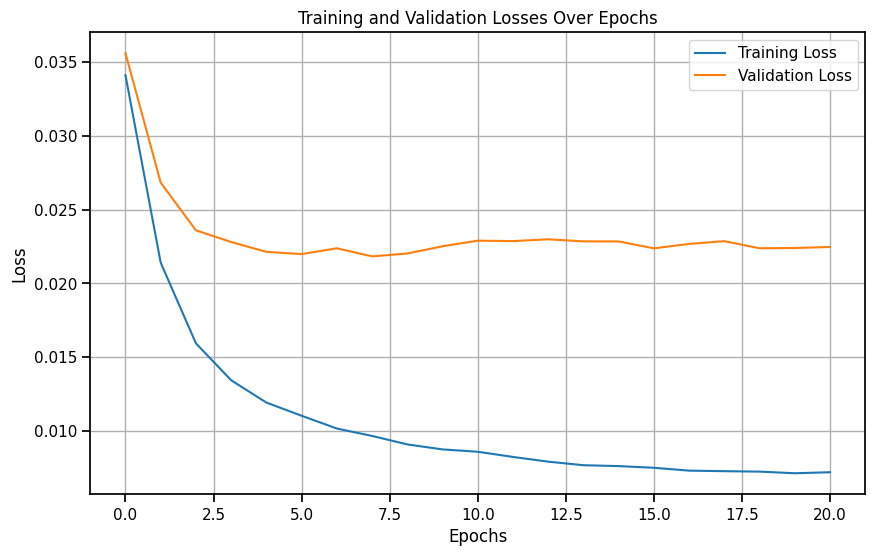

In [26]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [27]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model, metric = 'ev')

Train EV: 0.73 
Val EV: 0.47 
Test EV: 0.48 


## CL with Hypernetworks

Tutorial on the use of the hypnettorch package: https://github.com/chrhenning/hypnettorch/blob/master/hypnettorch/tutorials/getting_started.ipynb


From hypnettorch, we have:

- SimpleRNN: model which works as main networks and which has already the option or passing weights generated by other network in the forward loop.
    
- HMLP: A variety of hypernetworks is available in subpackage hypnettorch.hnets. The simplest being a fully-connected hypernetwork, see class hypnettorch.hnets.HMLP. Such simplistic hypernetwork is huge, as its parameter count is quadratic in the number of parameters of the corresponding main network. Therefore, several more sophisticated hypernetwork options are available, which are just as simple to use (most notably, hypnettorch.hnets.ChunkedHMLP). However, to keep this tutorial light, we don't discuss these options here.

In [32]:
from IPython.display import display, Markdown, Latex

In [28]:
from hypnettorch.mnets import SimpleRNN

In [30]:
model = SimpleRNN(n_in=1, rnn_layers=(10,)).to(device)

Creating a simple RNN with 251 weights.


In [33]:
try:
    Y = model.forward(xx_train, weights=None)
    print('Predicted classes: ', Y.max(dim=1)[1])
except:
    import sys
    import traceback
    display(Markdown('An **error** occured during the forward pass.'))
    traceback.print_exc(file=sys.stdout)

An **error** occured during the forward pass.

Traceback (most recent call last):
  File "C:\Users\nerea\AppData\Local\Temp\ipykernel_11964\2588806940.py", line 2, in <module>
    Y = model.forward(xx_train, weights=None)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nerea\anaconda3\envs\sinthlab\Lib\site-packages\hypnettorch\mnets\simple_rnn.py", line 915, in forward
    h, h_int = self.compute_hidden_states(h, d, rec_weights[d],
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nerea\anaconda3\envs\sinthlab\Lib\site-packages\hypnettorch\mnets\simple_rnn.py", line 1044, in compute_hidden_states
    h_0 = (torch.zeros(batch_size, n_hidden, device=x.device))
                                                    ^^^^^^^^
AttributeError: 'numpy.ndarray' object has no attribute 'device'
